In [178]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pylab import rcParams
import scipy as sp
from sklearn.metrics import log_loss
import sklearn.ensemble as ens
from sklearn.preprocessing import LabelEncoder
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import random
pd.options.mode.chained_assignment = None

## Create urls for data on github

url1 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/KenPom_2002_2017.csv'
url2 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/RegularSeasonDetailedResults.csv'
url3 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/Teams.csv'
url4 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/TourneyCompactResults.csv'
url5 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/TourneyDetailedResults.csv'
url6 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/Team_Lookup.csv'
url7 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/RegularSeasonCompactResults.csv'
url8 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/RegSeasonStack.csv'
url9 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/TourneyStack.csv'
##url8 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/Stage_1.csv'
##url9 = 'https://raw.github.com/WesleyPasfield/March_Madness_2017/master/Stage_2.csv'

## Load data from urls

kp = pd.read_csv(url1)
regSeason = pd.read_csv(url2)
teams = pd.read_csv(url3)
tourneyResults = pd.read_csv(url4)
tourneyDetail = pd.read_csv(url5)
teamLookup = pd.read_csv(url6)
regSeasonComp = pd.read_csv(url7)
regSeasonStack = pd.read_csv(url8)
tourneyStack = pd.read_csv(url9)
##stage1 = pd.read_csv(url8)
##stage2 = pd.read_csv(url9)

## Create indicators for regular season vs tourney data, then stack regular & tourney data

regSeasonComp['Type'] = 'Regular'
tourneyResults['Type'] = 'Tourney'

In [28]:
## Change KenPom names to match Kaggle Data

teamLookup.columns = ['Team', 'Team_Name']
kp2 = kp.merge(teamLookup, on = 'Team', how = 'left')

kp2.head()


,Rank,Team,Conf,W-L,AdjEM,AdjO,AdjD,AdjT,Luck,AdjEM_SOS,OppO,OppD,AdjEM_NCSOS,Year,Team_Name
0,1,Duke,ACC,31-4,34.14,118.9,84.7,75.9,-0.027,10.09,107.8,97.7,7.52,2002,Duke
1,2,Cincinnati,CUSA,31-4,30.15,116.0,85.9,68.6,0.002,7.45,105.2,97.8,5.41,2002,Cincinnati
2,3,Maryland,ACC,32-4,29.24,117.2,88.0,74.7,0.025,10.32,107.9,97.6,5.12,2002,Maryland
3,4,Kansas,B12,31-4,28.95,116.7,87.8,78.4,0.023,10.75,108.8,98.1,8.91,2002,Kansas
4,5,Oklahoma,B12,31-5,26.02,113.0,87.0,68.2,0.044,9.39,107.8,98.4,2.55,2002,Oklahoma


In [179]:
## Change column names for team lookup, then merge to match KP names & Kaggle Names

teamLookup.columns = ['Team', 'Team_Name']
kp2 = kp.merge(teamLookup, on = 'Team', how = 'left')

## Drop Null cases (Winston Salem St. , irrelevant), & Merge with Teams to get team_ids

kp2['nullCheck'] = pd.isnull(kp2['Team_Name'])
kp2= kp2[kp2.nullCheck != True]
kp3 = kp2.merge(teams, on = 'Team_Name', how = 'left')

## Convert variables to correct format & drop irrelevant variables

kp3.drop(['Rank','Team','Conf','W-L', 'nullCheck','Team_Name'],inplace=True,axis=1,errors='ignore')

## Add in total adjusted team efficiency (adjO - adjD) & create variable for Team_Year
kp3['Team_Id'] = kp3['Team_Id'].astype(str)
kp3['Team_Id'] = kp3['Team_Id'].apply(lambda x: x.split('.')[0])
kp3['Team_Year'] = kp3.Team_Id.map(str) + "_" + kp3.Year.map(str)
kp3 = kp3[kp3['Year'] != 2002]

## Drop Unnecessary Variables

kp3.drop(['Year', 'Team_Id', 'OppO', 'OppD', 'AdjEM_NCSOS', 'Luck'], inplace=True, axis=1, errors='ignore')
kp3.head()

,AdjEM,AdjO,AdjD,AdjT,AdjEM_SOS,Team_Year
327,34.83,122.6,87.8,70.2,0.70,1211_2003
328,30.20,123.1,92.9,64.6,9.10,1437_2003
329,29.02,116.8,87.8,60.0,11.39,1438_2003
330,28.85,119.5,90.6,71.4,7.34,1452_2003
331,27.91,117.5,89.6,68.3,10.69,1257_2003


In [180]:
regSeasonStack['Team_Year'] = regSeasonStack.Wteam.map(str) + '_' + regSeasonStack.Season.map(str)
regfull = regSeasonStack.groupby('Team_Year').mean()
regfull['three_pt_perc'] = regfull['Wfgm3'] * 3 / regfull['Wscore']
regfull['ft_perc'] = regfull['Wftm'] / regfull['Wscore']
regfull['tov_perc'] = regfull['Wto'] / (regfull['Wfga'] + (.44 * regfull['Wfta']) + regfull['Wto'])
regfull['efg_perc'] = (regfull['Wfgm'] + (regfull['Wfgm3'] * 0.5)) / regfull['Wfga']
regfull = regfull.reset_index()
regfull = regfull.ix[:,('Team_Year', 'Season', 'Wor', 'Wdr', 'three_pt_perc', 'ft_perc', 'tov_perc', 'efg_perc')]
regfull.head()

,Team_Year,Season,Wor,Wdr,three_pt_perc,ft_perc,tov_perc,efg_perc
0,1101_2014,2014,8.000000,20.333333,0.316742,0.250377,0.201432,0.471985
1,1101_2015,2015,8.250000,19.642857,0.356557,0.178571,0.177252,0.473347
2,1101_2016,2016,8.185185,22.518519,0.294274,0.220042,0.174350,0.505151
3,1102_2003,2003,4.178571,16.821429,0.409857,0.194635,0.194557,0.579443
4,1102_2004,2004,6.142857,15.357143,0.421958,0.185163,0.180557,0.583263


In [262]:
## Merge KP data w/ created regular season data

reg_model_final = regfull.merge(kp3, on = 'Team_Year', how='left')
regSeasonComp.drop(['Numot'],inplace=True,axis=1,errors='ignore')
regSeasonComp['Team_Year'] = regSeasonComp.Wteam.map(str) + '_' + regSeasonComp.Season.map(str)
regSeasonComp['Team_Year_L'] = regSeasonComp.Lteam.map(str) + '_' + regSeasonComp.Season.map(str)
reg_model_win = regSeasonComp.merge(reg_model_final, on = 'Team_Year', how = 'inner')
reg_model_win['game_id'] = reg_model_win.Daynum.map(str) + '_' + reg_model_win.Team_Year.map(str) + '_' + reg_model_win.Team_Year_L.map(str)
reg_model_win.drop(['Daynum','Season_y','Team_Year_L', 'Wteam', 'Lteam'], inplace=True, axis = 1, errors = 'ignore')
reg_model_win.head()

,Season_x,Wscore,Lscore,Wloc,Type,Team_Year,Wor,Wdr,three_pt_perc,ft_perc,tov_perc,efg_perc,AdjEM,AdjO,AdjD,AdjT,AdjEM_SOS,game_id
0,2003,68,62,N,Regular,1104_2003,13.571429,23.928571,0.275258,0.214433,0.166753,0.475953,11.24,104.2,93,66.1,6.32,10_1104_2003_1328_2003
1,2003,82,56,H,Regular,1104_2003,13.571429,23.928571,0.275258,0.214433,0.166753,0.475953,11.24,104.2,93,66.1,6.32,18_1104_2003_1106_2003
2,2003,80,65,H,Regular,1104_2003,13.571429,23.928571,0.275258,0.214433,0.166753,0.475953,11.24,104.2,93,66.1,6.32,21_1104_2003_1292_2003
3,2003,54,48,N,Regular,1104_2003,13.571429,23.928571,0.275258,0.214433,0.166753,0.475953,11.24,104.2,93,66.1,6.32,25_1104_2003_1326_2003
4,2003,89,61,H,Regular,1104_2003,13.571429,23.928571,0.275258,0.214433,0.166753,0.475953,11.24,104.2,93,66.1,6.32,29_1104_2003_1422_2003


In [275]:
tourneyResults.drop(['Numot'],inplace=True,axis=1,errors='ignore')
tourneyResults['Team_Year'] = tourneyResults.Wteam.map(str) + '_' + tourneyResults.Season.map(str)
tourneyResults['Team_Year_L'] = tourneyResults.Lteam.map(str) + '_' + tourneyResults.Season.map(str)
tourn_model_win = tourneyResults.merge(reg_model_final, on = 'Team_Year', how = 'inner')
tourn_model_win['game_id'] = tourn_model_win.Daynum.map(str) + '_' + tourn_model_win.Team_Year.map(str) + '_' + tourn_model_win.Team_Year_L.map(str)
tourn_model_win.drop(['Daynum','Season_y','Team_Year_L', 'Wteam', 'Lteam'], inplace=True, axis = 1, errors = 'ignore')
tourn_model_win.head()

,Season_x,Wscore,Lscore,Wloc,Type,Team_Year,Wor,Wdr,three_pt_perc,ft_perc,tov_perc,efg_perc,AdjEM,AdjO,AdjD,AdjT,AdjEM_SOS,game_id
0,2003,92,84,N,Tourney,1421_2003,12.275862,23.172414,0.273123,0.224213,0.197141,0.486339,6.80,108.3,101.5,68.3,-4.57,134_1421_2003_1411_2003
1,2003,80,51,N,Tourney,1112_2003,15.178571,27.642857,0.247695,0.205784,0.161593,0.514946,21.87,116.4,94.6,65.9,4.62,136_1112_2003_1436_2003
2,2003,96,95,N,Tourney,1112_2003,15.178571,27.642857,0.247695,0.205784,0.161593,0.514946,21.87,116.4,94.6,65.9,4.62,138_1112_2003_1211_2003
3,2003,88,71,N,Tourney,1112_2003,15.178571,27.642857,0.247695,0.205784,0.161593,0.514946,21.87,116.4,94.6,65.9,4.62,143_1112_2003_1323_2003
4,2003,84,71,N,Tourney,1113_2003,13.689655,23.310345,0.157966,0.231049,0.169846,0.513333,3.40,111.8,108.4,71.3,5.40,136_1113_2003_1272_2003


In [274]:
tourn_model_lose = tourneyResults.merge(reg_model_final, left_on = 'Team_Year_L', right_on = 'Team_Year', how = 'inner')
tourn_model_lose['game_id'] = tourn_model_lose.Daynum.map(str) + '_' + tourn_model_lose.Team_Year_x.map(str) + '_' + tourn_model_lose.Team_Year_L.map(str)
tourn_model_lose.drop(['Season_x', 'Season_y', 'Team_Year_y', 'Team_Year_x', 'Daynum', 'Wteam', 
                     'Wscore', 'Lteam', 'Lscore', 'Wloc', 'Type'], 
                    inplace = True, axis = 1, errors = 'ignore')
tourn_model_lose.head()
tourn_model_lose.columns = ['Team_Year_L', 'Wor', 'Wdr', 'three_pt_perc',
                         'ft_perc', 'tov_perc', 'efg_perc',
                         'AdjEM', 'AdjO', 'AdjD', 'AdjT', 'AdjEM_SOS', 'game_id']
tourn_model_lose.head()

,Team_Year_L,Wor,Wdr,three_pt_perc,ft_perc,tov_perc,efg_perc,AdjEM,AdjO,AdjD,AdjT,AdjEM_SOS,game_id
0,1411_2003,13.166667,24.800000,0.244505,0.239011,0.183868,0.501206,-4.04,104.6,108.7,68.7,-2.33,134_1421_2003_1411_2003
1,1436_2003,12.965517,25.724138,0.233469,0.189725,0.179145,0.491667,10.60,111.1,100.5,66.0,-3.11,136_1112_2003_1436_2003
2,1272_2003,14.068966,25.965517,0.281814,0.200833,0.164463,0.496264,7.89,106.6,98.8,68.6,0.06,136_1113_2003_1272_2003
3,1166_2003,10.878788,23.181818,0.301721,0.175143,0.167818,0.568829,20.88,118.5,97.6,70.9,7.29,136_1141_2003_1166_2003
4,1301_2003,9.733333,22.033333,0.330110,0.217772,0.185527,0.530937,5.77,113.1,107.4,71.2,7.28,136_1143_2003_1301_2003


In [198]:
reg_model_lose = regSeasonComp.merge(reg_model_final, left_on = 'Team_Year_L', right_on = 'Team_Year', how = 'inner')
reg_model_lose['game_id'] = reg_model_lose.Daynum.map(str) + '_' + reg_model_lose.Team_Year_x.map(str) + '_' + reg_model_lose.Team_Year_L.map(str)
reg_model_lose.drop(['Season_x', 'Season_y', 'Team_Year_y', 'Team_Year_x', 'Daynum', 'Wteam', 
                     'Wscore', 'Lteam', 'Lscore', 'Wloc', 'Type'], 
                    inplace = True, axis = 1, errors = 'ignore')
reg_model_lose.head()
reg_model_lose.columns = ['Team_Year_L', 'Wor', 'Wdr', 'three_pt_perc',
                         'ft_perc', 'tov_perc', 'efg_perc',
                         'AdjEM', 'AdjO', 'AdjD', 'AdjT', 'AdjEM_SOS', 'game_id']
reg_model_lose.head()

,Team_Year_L,Wor,Wdr,three_pt_perc,ft_perc,tov_perc,efg_perc,AdjEM,AdjO,AdjD,AdjT,AdjEM_SOS,game_id
0,1328_2003,12.133333,24.966667,0.314754,0.185012,0.154213,0.512972,8.99,106.6,97.6,70.6,12.54,10_1104_2003_1328_2003
1,1328_2003,12.133333,24.966667,0.314754,0.185012,0.154213,0.512972,8.99,106.6,97.6,70.6,12.54,54_1280_2003_1328_2003
2,1328_2003,12.133333,24.966667,0.314754,0.185012,0.154213,0.512972,8.99,106.6,97.6,70.6,12.54,70_1329_2003_1328_2003
3,1328_2003,12.133333,24.966667,0.314754,0.185012,0.154213,0.512972,8.99,106.6,97.6,70.6,12.54,98_1400_2003_1328_2003
4,1328_2003,12.133333,24.966667,0.314754,0.185012,0.154213,0.512972,8.99,106.6,97.6,70.6,12.54,114_1281_2003_1328_2003


In [277]:
reg_model_total = reg_model_win.merge(reg_model_lose, on = 'game_id', how = 'inner')
reg_model_total['Adj_Diff'] = reg_model_total['AdjEM_x'] - reg_model_total['AdjEM_y']
reg_model_total['Adj_T_Diff'] = reg_model_total['AdjT_x'] - reg_model_total['AdjT_y']
reg_model_total['AdjEM_SOS_Diff'] = reg_model_total['AdjEM_SOS_x'] - reg_model_total['AdjEM_SOS_y']
reg_model_total.head()

,Season_x,Wscore,Lscore,Wloc,Type,Team_Year,Wor_x,Wdr_x,three_pt_perc_x,ft_perc_x,...,tov_perc_y,efg_perc_y,AdjEM_y,AdjO_y,AdjD_y,AdjT_y,AdjEM_SOS_y,Adj_Diff,Adj_T_Diff,AdjEM_SOS_Diff
0,2003,68,62,N,Regular,1104_2003,13.571429,23.928571,0.275258,0.214433,...,0.154213,0.512972,8.99,106.6,97.6,70.6,12.54,2.25,-4.5,-6.22
1,2003,82,56,H,Regular,1104_2003,13.571429,23.928571,0.275258,0.214433,...,0.214109,0.479005,-20.17,88.7,108.8,69.4,-10.07,31.41,-3.3,16.39
2,2003,80,65,H,Regular,1104_2003,13.571429,23.928571,0.275258,0.214433,...,0.207774,0.521113,14.54,110.3,95.8,64.3,-0.81,-3.30,1.8,7.13
3,2003,54,48,N,Regular,1104_2003,13.571429,23.928571,0.275258,0.214433,...,0.181625,0.457276,11.15,111.3,100.2,68.5,7.47,0.09,-2.4,-1.15
4,2003,89,61,H,Regular,1104_2003,13.571429,23.928571,0.275258,0.214433,...,0.196792,0.493958,1.57,106.6,105.0,67.7,-1.52,9.67,-1.6,7.84


In [276]:
tourn_model_total = tourn_model_win.merge(tourn_model_lose, on = 'game_id', how = 'inner')
tourn_model_total['Adj_Diff'] = tourn_model_total['AdjEM_x'] - tourn_model_total['AdjEM_y']
tourn_model_total['Adj_T_Diff'] = tourn_model_total['AdjT_x'] - tourn_model_total['AdjT_y']
tourn_model_total['AdjEM_SOS_Diff'] = tourn_model_total['AdjEM_SOS_x'] - tourn_model_total['AdjEM_SOS_y']
tourn_model_total.head()

,Season_x,Wscore,Lscore,Wloc,Type,Team_Year,Wor_x,Wdr_x,three_pt_perc_x,ft_perc_x,...,tov_perc_y,efg_perc_y,AdjEM_y,AdjO_y,AdjD_y,AdjT_y,AdjEM_SOS_y,Adj_Diff,Adj_T_Diff,AdjEM_SOS_Diff
0,2003,92,84,N,Tourney,1421_2003,12.275862,23.172414,0.273123,0.224213,...,0.183868,0.501206,-4.04,104.6,108.7,68.7,-2.33,10.84,-0.4,-2.24
1,2003,80,51,N,Tourney,1112_2003,15.178571,27.642857,0.247695,0.205784,...,0.179145,0.491667,10.60,111.1,100.5,66.0,-3.11,11.27,-0.1,7.73
2,2003,96,95,N,Tourney,1112_2003,15.178571,27.642857,0.247695,0.205784,...,0.179957,0.534613,34.83,122.6,87.8,70.2,0.70,-12.96,-4.3,3.92
3,2003,88,71,N,Tourney,1112_2003,15.178571,27.642857,0.247695,0.205784,...,0.152983,0.517012,20.64,118.7,98.1,68.0,9.64,1.23,-2.1,-5.02
4,2003,84,71,N,Tourney,1113_2003,13.689655,23.310345,0.157966,0.231049,...,0.164463,0.496264,7.89,106.6,98.8,68.6,0.06,-4.49,2.7,5.34


In [282]:
reg_model_total = reg_model_win.merge(reg_model_lose, on = 'game_id', how = 'inner')
reg_model_total['Adj_Diff'] = reg_model_total['AdjEM_x'] - reg_model_total['AdjEM_y']
reg_model_total['Adj_T_Diff'] = reg_model_total['AdjT_x'] - reg_model_total['AdjT_y']
reg_model_total['AdjEM_SOS_Diff'] = reg_model_total['AdjEM_SOS_x'] - reg_model_total['AdjEM_SOS_y']

tourn_model_total = tourn_model_win.merge(tourn_model_lose, on = 'game_id', how = 'inner')
tourn_model_total['Adj_Diff'] = tourn_model_total['AdjEM_x'] - tourn_model_total['AdjEM_y']
tourn_model_total['Adj_T_Diff'] = tourn_model_total['AdjT_x'] - tourn_model_total['AdjT_y']
tourn_model_total['AdjEM_SOS_Diff'] = tourn_model_total['AdjEM_SOS_x'] - tourn_model_total['AdjEM_SOS_y']

cols_z = ['Adj_Diff', 'AdjO_x', 'AdjD_x', 'AdjO_y', 
          'AdjD_y', 'Adj_T_Diff', 'AdjEM_SOS_Diff',
         'Wor_x', 'Wdr_x', 'three_pt_perc_x', 'ft_perc_x',
         'tov_perc_x', 'efg_perc_x', 'Wor_y', 'Wdr_y',
         'three_pt_perc_y', 'ft_perc_y', 'tov_perc_y',
         'efg_perc_y']

reg_model_total2003 = reg_model_total[reg_model_total['Season_x'] == 2003].copy()
reg_model_total2004 = reg_model_total[reg_model_total['Season_x'] == 2004].copy()
reg_model_total2005 = reg_model_total[reg_model_total['Season_x'] == 2005].copy()
reg_model_total2006 = reg_model_total[reg_model_total['Season_x'] == 2006].copy()
reg_model_total2007 = reg_model_total[reg_model_total['Season_x'] == 2007].copy()
reg_model_total2008 = reg_model_total[reg_model_total['Season_x'] == 2008].copy()
reg_model_total2009 = reg_model_total[reg_model_total['Season_x'] == 2009].copy()
reg_model_total2010 = reg_model_total[reg_model_total['Season_x'] == 2010].copy()
reg_model_total2011 = reg_model_total[reg_model_total['Season_x'] == 2011].copy()
reg_model_total2012 = reg_model_total[reg_model_total['Season_x'] == 2012].copy()
reg_model_total2013 = reg_model_total[reg_model_total['Season_x'] == 2013].copy()
reg_model_total2014 = reg_model_total[reg_model_total['Season_x'] == 2014].copy()
reg_model_total2015 = reg_model_total[reg_model_total['Season_x'] == 2015].copy()
reg_model_total2016 = reg_model_total[reg_model_total['Season_x'] == 2016].copy()

tourn_model_total2003 = tourn_model_total[tourn_model_total['Season_x'] == 2003].copy()
tourn_model_total2004 = tourn_model_total[tourn_model_total['Season_x'] == 2004].copy()
tourn_model_total2005 = tourn_model_total[tourn_model_total['Season_x'] == 2005].copy()
tourn_model_total2006 = tourn_model_total[tourn_model_total['Season_x'] == 2006].copy()
tourn_model_total2007 = tourn_model_total[tourn_model_total['Season_x'] == 2007].copy()
tourn_model_total2008 = tourn_model_total[tourn_model_total['Season_x'] == 2008].copy()
tourn_model_total2009 = tourn_model_total[tourn_model_total['Season_x'] == 2009].copy()
tourn_model_total2010 = tourn_model_total[tourn_model_total['Season_x'] == 2010].copy()
tourn_model_total2011 = tourn_model_total[tourn_model_total['Season_x'] == 2011].copy()
tourn_model_total2012 = tourn_model_total[tourn_model_total['Season_x'] == 2012].copy()
tourn_model_total2013 = tourn_model_total[tourn_model_total['Season_x'] == 2013].copy()
tourn_model_total2014 = tourn_model_total[tourn_model_total['Season_x'] == 2014].copy()
tourn_model_total2015 = tourn_model_total[tourn_model_total['Season_x'] == 2015].copy()
tourn_model_total2016 = tourn_model_total[tourn_model_total['Season_x'] == 2016].copy()

for col in cols_z:
    col_zscore = col + '_zscore'
    reg_model_total2003[col_zscore] = (reg_model_total2003[col] - reg_model_total2003[col].mean())/reg_model_total2003[col].std(ddof=0)
    reg_model_total2004[col_zscore] = (reg_model_total2004[col] - reg_model_total2004[col].mean())/reg_model_total2004[col].std(ddof=0)
    reg_model_total2005[col_zscore] = (reg_model_total2005[col] - reg_model_total2005[col].mean())/reg_model_total2005[col].std(ddof=0)
    reg_model_total2006[col_zscore] = (reg_model_total2006[col] - reg_model_total2006[col].mean())/reg_model_total2006[col].std(ddof=0)
    reg_model_total2007[col_zscore] = (reg_model_total2007[col] - reg_model_total2007[col].mean())/reg_model_total2007[col].std(ddof=0)
    reg_model_total2008[col_zscore] = (reg_model_total2008[col] - reg_model_total2008[col].mean())/reg_model_total2008[col].std(ddof=0)
    reg_model_total2009[col_zscore] = (reg_model_total2009[col] - reg_model_total2009[col].mean())/reg_model_total2009[col].std(ddof=0)
    reg_model_total2010[col_zscore] = (reg_model_total2010[col] - reg_model_total2010[col].mean())/reg_model_total2010[col].std(ddof=0)
    reg_model_total2011[col_zscore] = (reg_model_total2011[col] - reg_model_total2011[col].mean())/reg_model_total2011[col].std(ddof=0)
    reg_model_total2012[col_zscore] = (reg_model_total2012[col] - reg_model_total2012[col].mean())/reg_model_total2012[col].std(ddof=0)
    reg_model_total2013[col_zscore] = (reg_model_total2013[col] - reg_model_total2013[col].mean())/reg_model_total2013[col].std(ddof=0)
    reg_model_total2014[col_zscore] = (reg_model_total2014[col] - reg_model_total2014[col].mean())/reg_model_total2014[col].std(ddof=0)
    reg_model_total2015[col_zscore] = (reg_model_total2015[col] - reg_model_total2015[col].mean())/reg_model_total2015[col].std(ddof=0)
    reg_model_total2016[col_zscore] = (reg_model_total2016[col] - reg_model_total2016[col].mean())/reg_model_total2016[col].std(ddof=0)
    tourn_model_total2003[col_zscore] = (tourn_model_total2003[col] - reg_model_total2003[col].mean())/reg_model_total2003[col].std(ddof=0)
    tourn_model_total2004[col_zscore] = (tourn_model_total2004[col] - reg_model_total2004[col].mean())/reg_model_total2004[col].std(ddof=0)
    tourn_model_total2005[col_zscore] = (tourn_model_total2005[col] - reg_model_total2005[col].mean())/reg_model_total2005[col].std(ddof=0)
    tourn_model_total2006[col_zscore] = (tourn_model_total2006[col] - reg_model_total2006[col].mean())/reg_model_total2006[col].std(ddof=0)
    tourn_model_total2007[col_zscore] = (tourn_model_total2007[col] - reg_model_total2007[col].mean())/reg_model_total2007[col].std(ddof=0)
    tourn_model_total2008[col_zscore] = (tourn_model_total2008[col] - reg_model_total2008[col].mean())/reg_model_total2008[col].std(ddof=0)
    tourn_model_total2009[col_zscore] = (tourn_model_total2009[col] - reg_model_total2009[col].mean())/reg_model_total2009[col].std(ddof=0)
    tourn_model_total2010[col_zscore] = (tourn_model_total2010[col] - reg_model_total2010[col].mean())/reg_model_total2010[col].std(ddof=0)
    tourn_model_total2011[col_zscore] = (tourn_model_total2011[col] - reg_model_total2011[col].mean())/reg_model_total2011[col].std(ddof=0)
    tourn_model_total2012[col_zscore] = (tourn_model_total2012[col] - reg_model_total2012[col].mean())/reg_model_total2012[col].std(ddof=0)
    tourn_model_total2013[col_zscore] = (tourn_model_total2013[col] - reg_model_total2013[col].mean())/reg_model_total2013[col].std(ddof=0)
    tourn_model_total2014[col_zscore] = (tourn_model_total2014[col] - reg_model_total2014[col].mean())/reg_model_total2014[col].std(ddof=0)
    tourn_model_total2015[col_zscore] = (tourn_model_total2015[col] - reg_model_total2015[col].mean())/reg_model_total2015[col].std(ddof=0)
    tourn_model_total2016[col_zscore] = (tourn_model_total2016[col] - reg_model_total2016[col].mean())/reg_model_total2016[col].std(ddof=0)

reg_model_total2003 = reg_model_total2003.ix[:,('game_id', 'Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2004 = reg_model_total2004.ix[:,('game_id', 'Team_Year', 'Team_Year_L','Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2005 = reg_model_total2005.ix[:,('game_id', 'Team_Year', 'Team_Year_L','Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2006 = reg_model_total2006.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2007 = reg_model_total2007.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2008 = reg_model_total2008.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2009 = reg_model_total2009.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2010 = reg_model_total2010.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2011 = reg_model_total2011.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2012 = reg_model_total2012.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2013 = reg_model_total2013.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2014 = reg_model_total2014.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2015 = reg_model_total2015.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2016 = reg_model_total2016.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]

stackedModel = [reg_model_total2003, reg_model_total2004, reg_model_total2005, reg_model_total2006, reg_model_total2007, reg_model_total2008,
          reg_model_total2009, reg_model_total2010, reg_model_total2011, reg_model_total2012, reg_model_total2013, reg_model_total2014,
          reg_model_total2015, reg_model_total2015, reg_model_total2016]

tourn_model_total2003 = tourn_model_total2003.ix[:,('game_id', 'Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2004 = tourn_model_total2004.ix[:,('game_id', 'Team_Year', 'Team_Year_L','Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2005 = tourn_model_total2005.ix[:,('game_id', 'Team_Year', 'Team_Year_L','Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2006 = tourn_model_total2006.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2007 = tourn_model_total2007.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2008 = tourn_model_total2008.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2009 = tourn_model_total2009.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2010 = tourn_model_total2010.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2011 = tourn_model_total2011.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2012 = tourn_model_total2012.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2013 = tourn_model_total2013.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2014 = tourn_model_total2014.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2015 = tourn_model_total2015.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2016 = tourn_model_total2016.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]

stackedModelTourn = [tourn_model_total2003, tourn_model_total2004, tourn_model_total2005, tourn_model_total2006, tourn_model_total2007, tourn_model_total2008,
          tourn_model_total2009, tourn_model_total2010, tourn_model_total2011, tourn_model_total2012, tourn_model_total2013, tourn_model_total2014,
          tourn_model_total2015, tourn_model_total2015, tourn_model_total2016]


regfinalmodel = pd.concat(stackedModel)
regfinalmodel['outcome'] = 1

tournfinalmodel = pd.concat(stackedModelTourn)
tournfinalmodel['outcome'] = 1
tournfinalmodel.head()

,game_id,Team_Year,Team_Year_L,Wscore,Lscore,Wloc,Adj_Diff_zscore,AdjO_x_zscore,AdjO_y_zscore,AdjD_x_zscore,...,ft_perc_x_zscore,tov_perc_x_zscore,efg_perc_x_zscore,Wor_y_zscore,Wdr_y_zscore,three_pt_perc_y_zscore,ft_perc_y_zscore,tov_perc_y_zscore,efg_perc_y_zscore,outcome
0,134_1421_2003_1411_2003,1421_2003,1411_2003,92,84,N,0.519430,0.306538,0.114548,-0.272533,...,0.674100,0.740658,-0.531893,0.841223,1.098089,-0.505953,1.356264,-0.275060,0.478175,1
1,136_1112_2003_1436_2003,1112_2003,1436_2003,80,51,N,0.551352,1.385900,1.012772,-1.322116,...,-0.046582,-1.070160,0.486301,0.730055,1.609664,-0.719473,-0.543172,-0.491830,0.155797,1
2,138_1112_2003_1211_2003,1112_2003,1211_2003,96,95,N,-1.247416,1.385900,2.601937,-1.322116,...,-0.046582,-1.070160,0.486301,0.160794,1.387374,0.157102,1.033669,-0.454594,1.607115,1
3,143_1112_2003_1323_2003,1112_2003,1323_2003,88,71,N,-0.193990,1.385900,2.063003,-1.322116,...,-0.046582,-1.070160,0.486301,-0.142279,2.244513,0.771045,0.495388,-1.692709,1.012316,1
4,136_1113_2003_1272_2003,1113_2003,1272_2003,84,71,N,-0.618627,0.772929,0.390925,0.777049,...,0.941403,-0.649730,0.428914,1.339889,1.743284,0.215843,-0.115092,-1.165776,0.311170,1


In [283]:
reg_model_total = reg_model_lose.merge(reg_model_win, on = 'game_id', how = 'inner')
reg_model_total['Adj_Diff'] = reg_model_total['AdjEM_x'] - reg_model_total['AdjEM_y']
reg_model_total['Adj_T_Diff'] = reg_model_total['AdjT_x'] - reg_model_total['AdjT_y']
reg_model_total['AdjEM_SOS_Diff'] = reg_model_total['AdjEM_SOS_x'] - reg_model_total['AdjEM_SOS_y']

tourn_model_total = tourn_model_lose.merge(tourn_model_win, on = 'game_id', how = 'inner')
tourn_model_total['Adj_Diff'] = tourn_model_total['AdjEM_x'] - tourn_model_total['AdjEM_y']
tourn_model_total['Adj_T_Diff'] = tourn_model_total['AdjT_x'] - tourn_model_total['AdjT_y']
tourn_model_total['AdjEM_SOS_Diff'] = tourn_model_total['AdjEM_SOS_x'] - tourn_model_total['AdjEM_SOS_y']


cols_z = ['Adj_Diff', 'AdjO_x', 'AdjD_x', 'AdjO_y', 
          'AdjD_y', 'Adj_T_Diff', 'AdjEM_SOS_Diff',
         'Wor_x', 'Wdr_x', 'three_pt_perc_x', 'ft_perc_x',
         'tov_perc_x', 'efg_perc_x', 'Wor_y', 'Wdr_y',
         'three_pt_perc_y', 'ft_perc_y', 'tov_perc_y',
         'efg_perc_y']

reg_model_total2003 = reg_model_total[reg_model_total['Season_x'] == 2003].copy()
reg_model_total2004 = reg_model_total[reg_model_total['Season_x'] == 2004].copy()
reg_model_total2005 = reg_model_total[reg_model_total['Season_x'] == 2005].copy()
reg_model_total2006 = reg_model_total[reg_model_total['Season_x'] == 2006].copy()
reg_model_total2007 = reg_model_total[reg_model_total['Season_x'] == 2007].copy()
reg_model_total2008 = reg_model_total[reg_model_total['Season_x'] == 2008].copy()
reg_model_total2009 = reg_model_total[reg_model_total['Season_x'] == 2009].copy()
reg_model_total2010 = reg_model_total[reg_model_total['Season_x'] == 2010].copy()
reg_model_total2011 = reg_model_total[reg_model_total['Season_x'] == 2011].copy()
reg_model_total2012 = reg_model_total[reg_model_total['Season_x'] == 2012].copy()
reg_model_total2013 = reg_model_total[reg_model_total['Season_x'] == 2013].copy()
reg_model_total2014 = reg_model_total[reg_model_total['Season_x'] == 2014].copy()
reg_model_total2015 = reg_model_total[reg_model_total['Season_x'] == 2015].copy()
reg_model_total2016 = reg_model_total[reg_model_total['Season_x'] == 2016].copy()

tourn_model_total2003 = tourn_model_total[tourn_model_total['Season_x'] == 2003].copy()
tourn_model_total2004 = tourn_model_total[tourn_model_total['Season_x'] == 2004].copy()
tourn_model_total2005 = tourn_model_total[tourn_model_total['Season_x'] == 2005].copy()
tourn_model_total2006 = tourn_model_total[tourn_model_total['Season_x'] == 2006].copy()
tourn_model_total2007 = tourn_model_total[tourn_model_total['Season_x'] == 2007].copy()
tourn_model_total2008 = tourn_model_total[tourn_model_total['Season_x'] == 2008].copy()
tourn_model_total2009 = tourn_model_total[tourn_model_total['Season_x'] == 2009].copy()
tourn_model_total2010 = tourn_model_total[tourn_model_total['Season_x'] == 2010].copy()
tourn_model_total2011 = tourn_model_total[tourn_model_total['Season_x'] == 2011].copy()
tourn_model_total2012 = tourn_model_total[tourn_model_total['Season_x'] == 2012].copy()
tourn_model_total2013 = tourn_model_total[tourn_model_total['Season_x'] == 2013].copy()
tourn_model_total2014 = tourn_model_total[tourn_model_total['Season_x'] == 2014].copy()
tourn_model_total2015 = tourn_model_total[tourn_model_total['Season_x'] == 2015].copy()
tourn_model_total2016 = tourn_model_total[tourn_model_total['Season_x'] == 2016].copy()

for col in cols_z:
    col_zscore = col + '_zscore'
    reg_model_total2003[col_zscore] = (reg_model_total2003[col] - reg_model_total2003[col].mean())/reg_model_total2003[col].std(ddof=0)
    reg_model_total2004[col_zscore] = (reg_model_total2004[col] - reg_model_total2004[col].mean())/reg_model_total2004[col].std(ddof=0)
    reg_model_total2005[col_zscore] = (reg_model_total2005[col] - reg_model_total2005[col].mean())/reg_model_total2005[col].std(ddof=0)
    reg_model_total2006[col_zscore] = (reg_model_total2006[col] - reg_model_total2006[col].mean())/reg_model_total2006[col].std(ddof=0)
    reg_model_total2007[col_zscore] = (reg_model_total2007[col] - reg_model_total2007[col].mean())/reg_model_total2007[col].std(ddof=0)
    reg_model_total2008[col_zscore] = (reg_model_total2008[col] - reg_model_total2008[col].mean())/reg_model_total2008[col].std(ddof=0)
    reg_model_total2009[col_zscore] = (reg_model_total2009[col] - reg_model_total2009[col].mean())/reg_model_total2009[col].std(ddof=0)
    reg_model_total2010[col_zscore] = (reg_model_total2010[col] - reg_model_total2010[col].mean())/reg_model_total2010[col].std(ddof=0)
    reg_model_total2011[col_zscore] = (reg_model_total2011[col] - reg_model_total2011[col].mean())/reg_model_total2011[col].std(ddof=0)
    reg_model_total2012[col_zscore] = (reg_model_total2012[col] - reg_model_total2012[col].mean())/reg_model_total2012[col].std(ddof=0)
    reg_model_total2013[col_zscore] = (reg_model_total2013[col] - reg_model_total2013[col].mean())/reg_model_total2013[col].std(ddof=0)
    reg_model_total2014[col_zscore] = (reg_model_total2014[col] - reg_model_total2014[col].mean())/reg_model_total2014[col].std(ddof=0)
    reg_model_total2015[col_zscore] = (reg_model_total2015[col] - reg_model_total2015[col].mean())/reg_model_total2015[col].std(ddof=0)
    reg_model_total2016[col_zscore] = (reg_model_total2016[col] - reg_model_total2016[col].mean())/reg_model_total2016[col].std(ddof=0)
    tourn_model_total2003[col_zscore] = (tourn_model_total2003[col] - reg_model_total2003[col].mean())/reg_model_total2003[col].std(ddof=0)
    tourn_model_total2004[col_zscore] = (tourn_model_total2004[col] - reg_model_total2004[col].mean())/reg_model_total2004[col].std(ddof=0)
    tourn_model_total2005[col_zscore] = (tourn_model_total2005[col] - reg_model_total2005[col].mean())/reg_model_total2005[col].std(ddof=0)
    tourn_model_total2006[col_zscore] = (tourn_model_total2006[col] - reg_model_total2006[col].mean())/reg_model_total2006[col].std(ddof=0)
    tourn_model_total2007[col_zscore] = (tourn_model_total2007[col] - reg_model_total2007[col].mean())/reg_model_total2007[col].std(ddof=0)
    tourn_model_total2008[col_zscore] = (tourn_model_total2008[col] - reg_model_total2008[col].mean())/reg_model_total2008[col].std(ddof=0)
    tourn_model_total2009[col_zscore] = (tourn_model_total2009[col] - reg_model_total2009[col].mean())/reg_model_total2009[col].std(ddof=0)
    tourn_model_total2010[col_zscore] = (tourn_model_total2010[col] - reg_model_total2010[col].mean())/reg_model_total2010[col].std(ddof=0)
    tourn_model_total2011[col_zscore] = (tourn_model_total2011[col] - reg_model_total2011[col].mean())/reg_model_total2011[col].std(ddof=0)
    tourn_model_total2012[col_zscore] = (tourn_model_total2012[col] - reg_model_total2012[col].mean())/reg_model_total2012[col].std(ddof=0)
    tourn_model_total2013[col_zscore] = (tourn_model_total2013[col] - reg_model_total2013[col].mean())/reg_model_total2013[col].std(ddof=0)
    tourn_model_total2014[col_zscore] = (tourn_model_total2014[col] - reg_model_total2014[col].mean())/reg_model_total2014[col].std(ddof=0)
    tourn_model_total2015[col_zscore] = (tourn_model_total2015[col] - reg_model_total2015[col].mean())/reg_model_total2015[col].std(ddof=0)
    tourn_model_total2016[col_zscore] = (tourn_model_total2016[col] - reg_model_total2016[col].mean())/reg_model_total2016[col].std(ddof=0)

reg_model_total2003 = reg_model_total2003.ix[:,('game_id', 'Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2004 = reg_model_total2004.ix[:,('game_id', 'Team_Year', 'Team_Year_L','Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2005 = reg_model_total2005.ix[:,('game_id', 'Team_Year', 'Team_Year_L','Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2006 = reg_model_total2006.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2007 = reg_model_total2007.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2008 = reg_model_total2008.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2009 = reg_model_total2009.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2010 = reg_model_total2010.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2011 = reg_model_total2011.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2012 = reg_model_total2012.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2013 = reg_model_total2013.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2014 = reg_model_total2014.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2015 = reg_model_total2015.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
reg_model_total2016 = reg_model_total2016.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]

stackedModel = [reg_model_total2003, reg_model_total2004, reg_model_total2005, reg_model_total2006, reg_model_total2007, reg_model_total2008,
          reg_model_total2009, reg_model_total2010, reg_model_total2011, reg_model_total2012, reg_model_total2013, reg_model_total2014,
          reg_model_total2015, reg_model_total2015, reg_model_total2016]

tourn_model_total2003 = tourn_model_total2003.ix[:,('game_id', 'Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2004 = tourn_model_total2004.ix[:,('game_id', 'Team_Year', 'Team_Year_L','Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2005 = tourn_model_total2005.ix[:,('game_id', 'Team_Year', 'Team_Year_L','Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2006 = tourn_model_total2006.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2007 = tourn_model_total2007.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2008 = tourn_model_total2008.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2009 = tourn_model_total2009.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2010 = tourn_model_total2010.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2011 = tourn_model_total2011.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2012 = tourn_model_total2012.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2013 = tourn_model_total2013.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2014 = tourn_model_total2014.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2015 = tourn_model_total2015.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]
tourn_model_total2016 = tourn_model_total2016.ix[:,('game_id','Team_Year', 'Team_Year_L', 'Wscore', 'Lscore',
                                'Wloc', 'Adj_Diff_zscore', 'AdjO_x_zscore', 'AdjO_y_zscore',
                                'AdjD_x_zscore', 'AdjD_y_zscore', 'Adj_T_Diff_zscore', 
                                'AdjEM_SOS_Diff_zscore','Wor_x_zscore', 'Wdr_x_zscore',
                                'three_pt_perc_x_zscore', 'ft_perc_x_zscore', 
                                'tov_perc_x_zscore', 'efg_perc_x_zscore',
                                'Wor_y_zscore', 'Wdr_y_zscore', 'three_pt_perc_y_zscore',
                                'ft_perc_y_zscore', 'tov_perc_y_zscore', 'efg_perc_y_zscore'
                                )]

stackedModelTourn = [tourn_model_total2003, tourn_model_total2004, tourn_model_total2005, tourn_model_total2006, tourn_model_total2007, tourn_model_total2008,
          tourn_model_total2009, tourn_model_total2010, tourn_model_total2011, tourn_model_total2012, tourn_model_total2013, tourn_model_total2014,
          tourn_model_total2015, tourn_model_total2015, tourn_model_total2016]


#reg_model_total.drop(['AdjEM', 'AdjT', 'AdjEM_SOS', 'L_AdjEM', 'L_AdjT', 'L_Adj_Sos',
#                     'Wor', 'Dor', 'Lor', 'Ldr', 'ft_perc', 'tov_perc', 'three_pt_perc','efg_perc',
#                     'L_ft_perc', 'L_tov_perc', 'L_three_pt_perc', 'L_efg_],
#                    inplace = True, axis = 1, errors = 'ignore')

regfinalmodel_2 = pd.concat(stackedModel)
regfinalmodel_2['outcome'] = 0

tournfinalmodel_2 = pd.concat(stackedModelTourn)
tournfinalmodel_2['outcome'] = 0
tournfinalmodel_2.head()

,game_id,Team_Year,Team_Year_L,Wscore,Lscore,Wloc,Adj_Diff_zscore,AdjO_x_zscore,AdjO_y_zscore,AdjD_x_zscore,...,ft_perc_x_zscore,tov_perc_x_zscore,efg_perc_x_zscore,Wor_y_zscore,Wdr_y_zscore,three_pt_perc_y_zscore,ft_perc_y_zscore,tov_perc_y_zscore,efg_perc_y_zscore,outcome
0,134_1421_2003_1411_2003,1421_2003,1411_2003,92,84,N,-0.519430,0.114548,0.306538,0.589157,...,1.356264,-0.275060,0.478175,0.245911,-0.152783,0.092138,0.674100,0.740658,-0.531893,0
1,136_1112_2003_1436_2003,1112_2003,1436_2003,80,51,N,-0.551352,1.012772,1.385900,-0.680639,...,-0.543172,-0.491830,0.155797,1.919683,2.367661,-0.405864,-0.046582,-1.070160,0.486301,0
2,136_1113_2003_1272_2003,1113_2003,1272_2003,84,71,N,0.618627,0.390925,0.772929,-0.943890,...,-0.115092,-1.165776,0.311170,1.061138,-0.075018,-2.163133,0.941403,-0.649730,0.428914,0
3,136_1141_2003_1166_2003,1141_2003,1166_2003,79,73,N,1.967517,2.035365,0.972810,-1.129714,...,-1.105150,-1.011751,2.763398,-0.728384,-0.094459,-0.201134,1.406335,2.029224,2.446763,0
4,136_1143_2003_1301_2003,1143_2003,1301_2003,76,74,N,-0.342003,1.289148,-0.026599,0.387847,...,0.537714,-0.198898,1.482902,-0.350596,0.527667,-0.197517,-1.069343,-0.441773,0.675394,0


In [ ]:
## Replicate above process for tourney data, then stack with "Type" variable included to indicate tourney vs. reg season

In [287]:
## Create dataset of team matchups
## Create model that predicts score for each team based on opponent
## Join scores to find expected outcome
win_lose = [regfinalmodel, regfinalmodel_2]
regfinalmodel_all = pd.concat(win_lose)
regfinalmodel_all['Wloc'] = np.where(regfinalmodel_all['Wloc']=='H', 1, 
                                     np.where(regfinalmodel_all['Wloc']=='N', 0, -1))
regfinalmodel_all = regfinalmodel_all.dropna()
regfinalmodel_bin = regfinalmodel_all.copy()
regfinalmodel_cont = regfinalmodel_all.copy()
regfinalmodel_bin.drop(['Wscore', 'Lscore', 'Team_Year', 'Team_Year_L'], inplace = True, axis = 1, errors = 'ignore')
regfinalmodel_cont.drop(['outcome', 'Team_Year', 'Team_Year_L'], inplace = True, axis = 1, errors = 'ignore')



In [324]:
win_lose_tourn = [tournfinalmodel, tournfinalmodel_2]
tournfinalmodel_all = pd.concat(win_lose_tourn)
tournfinalmodel_all['Wloc'] = np.where(tournfinalmodel_all['Wloc']=='H', 1, 
                                     np.where(tournfinalmodel_all['Wloc']=='N', 0, -1))
tournfinalmodel_all = tournfinalmodel_all.dropna()
tournfinalmodel_bin = tournfinalmodel_all.copy()
tournfinalmodel_cont = tournfinalmodel_all.copy()
tournfinalmodel_bin.drop(['Wscore', 'Lscore', 'Team_Year', 'Team_Year_L'], inplace = True, axis = 1, errors = 'ignore')
tournfinalmodel_cont.drop(['outcome', 'Team_Year', 'Team_Year_L'], inplace = True, axis = 1, errors = 'ignore')
tournfinalmodel_bin.head()

,game_id,Wloc,Adj_Diff_zscore,AdjO_x_zscore,AdjO_y_zscore,AdjD_x_zscore,AdjD_y_zscore,Adj_T_Diff_zscore,AdjEM_SOS_Diff_zscore,Wor_x_zscore,...,ft_perc_x_zscore,tov_perc_x_zscore,efg_perc_x_zscore,Wor_y_zscore,Wdr_y_zscore,three_pt_perc_y_zscore,ft_perc_y_zscore,tov_perc_y_zscore,efg_perc_y_zscore,outcome
0,134_1421_2003_1411_2003,0,0.519430,0.306538,0.114548,-0.272533,0.589157,-0.070703,-0.727700,0.245911,...,0.674100,0.740658,-0.531893,0.841223,1.098089,-0.505953,1.356264,-0.275060,0.478175,1
1,136_1112_2003_1436_2003,0,0.551352,1.385900,1.012772,-1.322116,-0.680639,0.001252,1.253310,1.919683,...,-0.046582,-1.070160,0.486301,0.730055,1.609664,-0.719473,-0.543172,-0.491830,0.155797,1
2,138_1112_2003_1211_2003,0,-1.247416,1.385900,2.601937,-1.322116,-2.647275,-1.006109,0.496274,1.919683,...,-0.046582,-1.070160,0.486301,0.160794,1.387374,0.157102,1.033669,-0.454594,1.607115,1
3,143_1112_2003_1323_2003,0,-0.193990,1.385900,2.063003,-1.322116,-1.052287,-0.478444,-1.280078,1.919683,...,-0.046582,-1.070160,0.486301,-0.142279,2.244513,0.771045,0.495388,-1.692709,1.012316,1
4,136_1113_2003_1272_2003,0,-0.618627,0.772929,0.390925,0.777049,-0.943890,0.672825,0.778424,1.061138,...,0.941403,-0.649730,0.428914,1.339889,1.743284,0.215843,-0.115092,-1.165776,0.311170,1


In [297]:
Target = 'outcome'
IDcol = 'game_id'

rcParams['figure.figsize'] = 12,4
random.seed(42)
tIndex = np.random.rand(len(regfinalmodel_bin)) < 0.75
X_train = regfinalmodel_bin[tIndex]
X_test = regfinalmodel_bin[~tIndex]
X_test_tourn = tournfinalmodel_bin.copy()
X_testWin = pd.DataFrame({'outcome': X_test['outcome'],
                         'id': X_test['game_id']})
X_test_tournWin = pd.DataFrame({'outcome': X_test_tourn['outcome'],
                            'id': X_test_tourn['game_id']})
X_trainWin = pd.DataFrame({'outcome': X_train['outcome'],
                         'id': X_train['game_id']})

def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds =5):
    ## Fit algorithm to the data
    alg.fit(dtrain[predictors], dtrain['outcome'])
    ## Predict Training Set
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob=alg.predict_proba(dtrain[predictors])[:,1]
    ## Perform Cross validation
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['outcome'], 
                                                    cv=cv_folds, scoring = 'roc_auc')
    ## Print model report
    print("\nModel Report")
    print("Accuracy: %.4g" % metrics.accuracy_score(dtrain['outcome'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['outcome'], dtrain_predprob))
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" 
        % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))
        
    ## Print Feature Importance
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature_Importances')
        
def modelfitXGB(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['outcome'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['outcome'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['outcome'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['outcome'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

        
predictors = [x for x in X_train.columns if x not in [Target, IDcol]]

## Grid Search example - removed grid searches for ease of viewing

#param_test1 = {'n_estimators': [50, 75, 100]}
#gSearch1 = GridSearchCV(estimator = ens.GradientBoostingClassifier(max_depth =5 , learning_rate = 0.1, min_samples_split = 500,
#                                          min_samples_leaf = 50, max_features = 'sqrt', subsample= .80,
#                                         random_state = 10),
#param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
#gSearch1.fit(X_train[predictors],X_train[Target])
#modelfit(gSearch1, X_train, predictors)



Model Report
Accuracy: 0.9701
AUC Score (Train): 0.996251


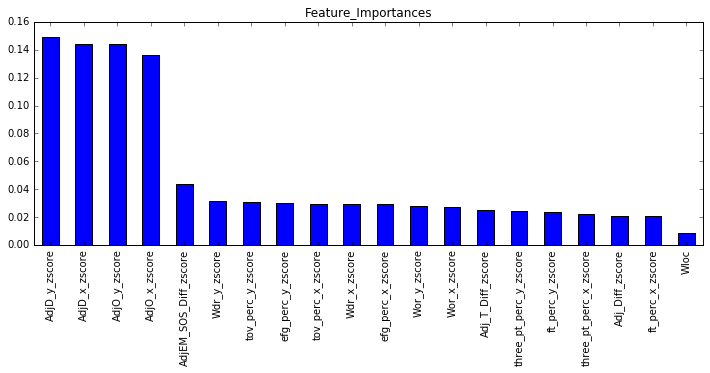

In [289]:
gbmFin = ens.GradientBoostingClassifier(max_depth = 7 , learning_rate = 0.025, min_samples_split = 250,
                                          min_samples_leaf = 50, max_features = 'sqrt', subsample= .80,
                                         random_state = 10, n_estimators = 1000)
modelfit(gbmFin, X_train, predictors, performCV = False, printFeatureImportance = True)


Model Report
Accuracy : 0.9663
AUC Score (Train): 0.995646


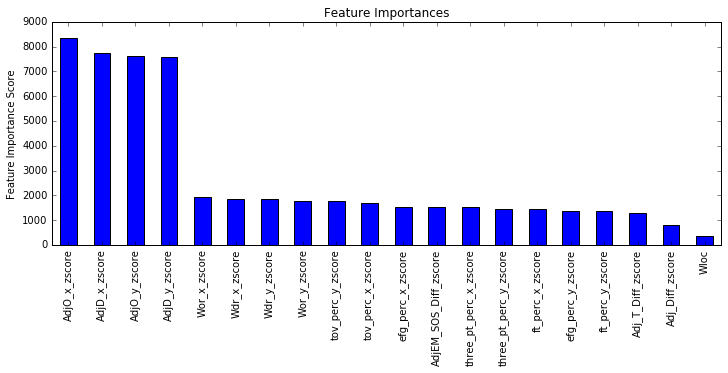

In [294]:
## xgboost model

xgb2 = XGBClassifier(max_depth = 7 , learning_rate = 0.015, n_estimators = 1000,
                        subsample= .80, colsample_bytree =.75, reg_lambda = 3, gamma = 0.5,
                        objective = 'binary:logistic')

modelfitXGB(xgb2, X_train, predictors)

In [295]:
## Purpose of this chart is to get an understanding of how predicted probabilities translate to actual wins
## As well as an understanding of the prediction distribution across percentages

## NOTE - in order to run this need to have a completed model, then create a dataframe 
## that contains the predicted chance of winning & actual outcome for each game in the test set

## Create dataframe with predicted win % and actual result for each game from predicted test set
## predTest DataFrame houses my predictions, and X_testWin houses the outcome of the predicted games

def h_notype(df, df2, model):

    ## Pull out desired type (regular vs. tournament)
    
    df.drop(['game_id','outcome'],inplace=True,axis=1,errors='ignore')
    predTest = model.predict_proba(df)
    predTestComp = pd.DataFrame({'pred' : predTest[:,1],
                             'outcome': df2['outcome'],
                            'game_id' : df2['id']})

    ## Round prediction % for ease of interpretation

    predTestComp['predRound'] = np.round(predTestComp['pred'], decimals=2)      
    
    ## Find Difference in predictions vs actuals, as well as max miss & print results
    ## Also find number of "correct" predictions - above 50% and win / below 50% and loss
    ## Then print the results
    
    predTestComp['diff'] = abs(predTestComp['outcome'] - predTestComp['pred'])
    maximum = np.round(max(predTestComp['diff']),decimals = 4)
    def f(df3):
        if df3['diff'] < 0.5:
            val = 1
        else:
            val = 0
        return val

    predTestComp['bin'] = predTestComp.apply(f, axis=1)
    accuracy = np.round(sum(predTestComp['bin']) / len(predTestComp),decimals = 4)
    print('The Biggest Upset is', maximum)
    print('Accuracy is', accuracy)
    
    ## Now Calc AUC
    
    y = np.array(predTestComp['outcome']+1)
    pred = np.array(predTestComp['pred'])
    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
    auc = np.round(metrics.auc(fpr, tpr),decimals=4)
    print('AUC is', auc)
    predTestComp.drop(['id'],inplace=True,axis=1,errors='ignore')
    
    ## Now Calc LogLoss
    
    yLL = list(predTestComp['outcome'])
    logL = log_loss(yLL, predTest)
    print('LogLoss is', logL)
    
    ## Group predictions by predicted win percentage, then find the total number of wins, games & average win percentage 
    ## For each rounded prediction value (0-100%)

    grouped = predTestComp.groupby(['predRound'])['outcome'].agg(['sum', 'count', 'mean']).reset_index()

    ## Create subplots that have win% on the x axis, and number of games on the secondary axis
    fig, tsax = plt.subplots(figsize=(12,5))
    barax = tsax.twinx() 

    ## Create bar chart based on the count of games for each predicted percentage

    barax.bar(grouped.index, grouped['count'], facecolor=(0.5, 0.5, 0.5), alpha=0.3) 

    ## Create line chart that shows the average win percentage by predicted percentage

    fig.tight_layout()
    tsax.plot(grouped.index, grouped['mean'], color = 'b')

    ## Set axis & data point labels as well as tick distribution

    barax.set_ylabel('Number of Games')
    barax.xaxis.tick_top()
    tsax.set_ylabel('Win %')
    tsax.set_xlabel('Predicted Win %')
    tsax.set_xlim([0, 101])
    tsax.set_ylim([0, 1])
    plt.xticks(np.arange(0, 101, 10))
    percListX = ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
    percListY = ['0%', '20%', '40%', '60%', '80%', '100%']
    tsax.set_xticklabels(percListX)
    tsax.set_yticklabels(percListY)

    ## Put line graph in front of bar chart

    tsax.set_zorder(barax.get_zorder()+1) 
    tsax.patch.set_visible(False) # hide the 'canvas' 

    ## Create legend labels - necessary because it's a subplot

    line_patch = mpatches.Patch(color='blue', label='Percentage of Games Won')
    bar_patch = mpatches.Patch(color='gray', label='Number of Games')
    plt.legend(handles=[line_patch, bar_patch], loc = 'upper center')
    plt.savefig('output.png', dpi=300)
                  

In [113]:
## Same as above function but for ensemble model
## In future - turn into if statement in one function to evaluate ensemble or individual model
## Also don't have log loss working for ensemble eval

def e(df, df2, Type):
    df.drop(['id','Win','Type'],inplace=True,axis=1,errors='ignore')
    predTest = gbmFin.predict_proba(df)
    predTest2 = xgb2.predict_proba(df)
    predTestComp = pd.DataFrame({'pred' : predTest[:,1],
                                 'pred2' : predTest2[:,1],
                                 'Win': df2['Win'],
                                'Type': df2['Type']})
    predTestComp['predAvg'] = predTestComp[["pred", "pred2"]].mean(axis=1)

    ## Round prediction % for ease of interpretation

    predTestComp['predRound'] = np.round(predTestComp['predAvg'], decimals=2) 
    
    ## Pull out desired type (regular vs. tournament)
    
    predTestComp = predTestComp[predTestComp['Type']==Type] 
    
    ## Find Difference in predictions vs actuals, as well as max miss & print results
    ## Also find number of "correct" predictions - above 50% and win / below 50% and loss
    ## Then print the results
    
    predTestComp['diff'] = abs(predTestComp['Win'] - predTestComp['predAvg'])
    maximum = np.round(max(predTestComp['diff']),decimals = 4)
    def f(df3):
        if df3['diff'] < 0.5:
            val = 1
        else:
            val = 0
        return val

    predTestComp['bin'] = predTestComp.apply(f, axis=1)
    accuracy = np.round(sum(predTestComp['bin']) / len(predTestComp),decimals = 4)
    print('The Biggest Upset Is', maximum)
    print('Accuracy Is', accuracy)
    
    ## Now Calc AUC
    
    y = np.array(predTestComp['Win']+1)
    pred = np.array(predTestComp['predAvg'])
    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
    auc = np.round(metrics.auc(fpr, tpr),decimals=4)
    print('AUC is', auc)
    predTestComp.drop(['Type'],inplace=True,axis=1,errors='ignore')
    predTestComp.drop(['id'],inplace=True,axis=1,errors='ignore')
    
    ## Group predictions by predicted win percentage, then find the total number of wins, games & average win percentage 
    ## For each rounded prediction value (0-100%)

    grouped = predTestComp.groupby(['predRound'])['Win'].agg(['sum', 'count', 'mean']).reset_index()

    ## Create subplots that have win% on the x axis, and number of games on the secondary axis
    fig, tsax = plt.subplots(figsize=(12,5))
    barax = tsax.twinx() 

    ## Create bar chart based on the count of games for each predicted percentage

    barax.bar(grouped.index, grouped['count'], facecolor=(0.5, 0.5, 0.5), alpha=0.3) 

    ## Create line chart that shows the average win percentage by predicted percentage

    fig.tight_layout()
    tsax.plot(grouped.index, grouped['mean'], color = 'b')

    ## Set axis & data point labels as well as tick distribution

    barax.set_ylabel('Number of Games')
    barax.xaxis.tick_top()
    tsax.set_ylabel('Win %')
    tsax.set_xlabel('Predicted Win %')
    tsax.set_xlim([0, 101])
    tsax.set_ylim([0, 1])
    plt.xticks(np.arange(0, 101, 10))
    percListX = ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']
    percListY = ['0%', '20%', '40%', '60%', '80%', '100%']
    tsax.set_xticklabels(percListX)
    tsax.set_yticklabels(percListY)

    ## Put line graph in front of bar chart

    tsax.set_zorder(barax.get_zorder()+1) 
    tsax.patch.set_visible(False) # hide the 'canvas' 

    ## Create legend labels - necessary because it's a subplot

    line_patch = mpatches.Patch(color='blue', label='Percentage of Games Won')
    bar_patch = mpatches.Patch(color='gray', label='Number of Games')
    plt.legend(handles=[line_patch, bar_patch], loc = 'upper center')
    plt.savefig('output.png', dpi=300)

The Biggest Upset is 0.7936
Accuracy is 0.9776
AUC is 0.9976
LogLoss is 0.198172477144


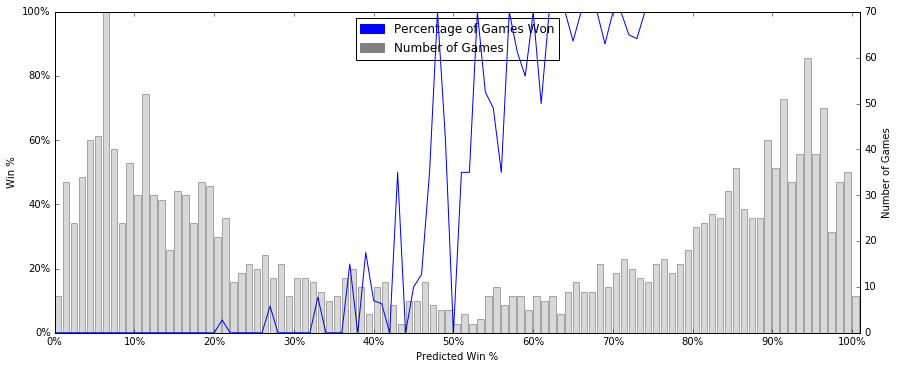

In [302]:
#h_notype(X_train, X_trainWin, gbmFin)
#h_notype(X_test, X_testWin, gbmFin)
#h_notype(X_test_tourn, X_test_tournWin, gbmFin)
h_notype(X_test_tourn, X_test_tournWin, xgb2)

In [327]:
import os
def raw_preds(df, df2, model):

    ## Pull out desired type (regular vs. tournament)
    
    df.drop(['game_id','outcome'],inplace=True,axis=1,errors='ignore')
    predTest = model.predict_proba(df)
    predTestComp = pd.DataFrame({'pred' : predTest[:,1],
                             'outcome': df2['outcome'],
                            'game_id' : df2['id']})

    ## Round prediction % for ease of interpretation

    predTestComp['predRound'] = np.round(predTestComp['pred'], decimals=2)  
    predTestComp['miss'] = abs(predTestComp['outcome'] - predTestComp['pred'])
    predTestComp = predTestComp.sort_values('miss', ascending = False)
    return predTestComp
    
fin = raw_preds(X_test_tourn, X_test_tournWin, xgb2)
path = '/Users/Wesley/Documents/Kaggle/MarchMadness/2017'
os.chdir(path)

fin.to_csv('game_miss.csv')
tournfinalmodel_bin.to_csv('game_checker.csv')
kp3.to_csv('data_checker.csv')

In [252]:
## Evaluate predictions on training & test sets for gbm & xgboost

rcParams['figure.figsize'] = 12,4
random.seed(42)
tIndex = np.random.rand(len(kpFinal)) < 0.75
X_train = kpFinal[tIndex]
X_test = kpFinal[~tIndex]
X_testWin = pd.DataFrame({'Win': X_test['Win'],
                         'id': X_test['id'],
                        'Type': X_test['Type']})
X_trainWin = pd.DataFrame({'Win': X_train['Win'],
                            'id': X_train['id'],
                            'Type': X_train['Type']})

## Uncomment one of the below function calls to visualize results

h_notype(X_train, X_trainWin, 'Regular', gbmFin)
#h(X_train, X_trainWin, 'Tourney', gbmFin)
#h(X_test, X_testWin, 'Regular', gbmFin)
#h(X_test, X_testWin, 'Tourney', gbmFin)
#h(X_train, X_trainWin, 'Regular', xgb2)
#h(X_train, X_trainWin, 'Tourney', xgb2)
#h(X_test, X_testWin, 'Regular', xgb2)
#h(X_test, X_testWin, 'Tourney', xgb2)

## Evaluate predictions on training & test sets for ensemble

#e(X_train, X_trainWin, 'Regular')
#e(X_train, X_trainWin, 'Tourney')
#e(X_test, X_testWin, 'Regular')
#e(X_test, X_testWin, 'Tourney')



NameError: name 'kpFinal' is not defined

In [104]:
import os

X_testStage2 = kpFinalStage2

predSub = gbmFin.predict_proba(X_testStage2)
predSub2 = xgb2.predict_proba(X_testStage2)
predSub3 = pd.DataFrame({'pred1' : predSub[:,1],
                        'pred2' : predSub2[:,1]})
predSub3['predAvg'] = predSub3[["pred1", "pred2"]].mean(axis=1)

submission = pd.DataFrame({'id': kpModelStage2['id'],
                           'pred' : predSub[:,1]})
submission2 = pd.DataFrame({'id': kpModelStage2['id'],
                          'pred' : predSub2[:,1]})
submission3 = pd.DataFrame({'id': kpModelStage2['id'],
                           'predAvg' : predSub3['predAvg']})


path = '/Users/Wesley/Documents/Kaggle/MarchMadness'
os.chdir(path)

submission.to_csv('gbmSubmission.csv')
submission2.to_csv('xgbSubmission.csv')
submission3.to_csv('ensemble.csv')



In [ ]:
## CURRENTLY NOT WORKING , DO NOT RUN

## NEED TO BE ABLE TO RUN WITHOUT HAVING TO RERUN OTHER CODE

kpGraph2 = kpMergeFinal.drop('Team_Year', axis =1, inplace = True)
kpCol = list(kpGraph2.columns)
axes = plt.gca()

for column in kpGraph2:
    s = kpGraph2[column]
    mu = np.mean(kpGraph2[column])
    sigma = np.std(kpGraph2[column])
    count, bins, ignored = plt.hist(s, 30, normed=True)
    plt.plot(bins, 1/(sigma * np.sqrt(2*np.pi)) *
       np.exp( - (bins - mu) ** 2 / (2 * sigma ** 2)),
       linewidth = 2, color = 'r', label=column)
    plt.legend(loc=0)
    plt.figure()
    
## NOTE MUST RERUN IN [130] before continuing to replace Team_Year. Need to figure out better way of 
## deleting team_year from these graphs, but not having to rerun code to replace it

In [ ]:
## Get Team_Year combinations, then create df for all game winners & losers

allDetail['W_Team_Year'] = allDetail.Season.map(str) + '_' + allDetail.Wteam.map(str)
allDetail['L_Team_Year'] = allDetail.Season.map(str) + '_' + allDetail.Lteam.map(str)
regSeasonFin= allDetail[['W_Team_Year', 'L_Team_Year', 'possW', 'possL', 'possDiff']]

## Create KP file that just has adjO, adjD, & AdjS for merging

kp4 = kp3[['Team_Year', 'AdjO','AdjD','AdjS']]

## Merge Ken Pom data with regSeason data
## Understand how season long stats predict game by game

regSeasonFin2 = regSeasonFin.merge(kp4, left_on = 'W_Team_Year', right_on = 'Team_Year')
regSeasonFin3 = regSeasonFin2.merge(kp4, left_on = 'L_Team_Year', right_on = 'Team_Year')
regSeasonFin3.columns = ['W_Team_Year', 'L_Team_Year', 'possW', 'possL', 
                         'possDiff', 'W_Team_Year2','W_AdjO','W_AdjD','W_AdjS',
                        'L_Team_Year2', 'L_AdjO', 'L_AdjD', 'L_AdjS']

## Find game by game season based expected differences between two teams, then compare with averages

## Create z score for all variables

cols = list(kp3.columns)
cols.remove('Team_Year')



for col in cols:
    col_zscore = col + '_zscore'
    kp3[col_zscore] = (kp3[col] - kp3[col].mean())/kp3[col].std(ddof=0)
    
# Pull out only z score tranformed variables
kpFin = kp3[kp3.columns[10:21]]
kpFin.head()

regSeasonFin4 = regSeasonFin3
regSeasonFin4['W_expO'] = (regSeasonFin3['W_AdjO'] + regSeasonFin3['L_AdjD']) / 2
regSeasonFin4['W_expD'] = (regSeasonFin3['W_AdjD'] + regSeasonFin3['L_AdjO']) / 2
regSeasonFin4['L_expO'] = (regSeasonFin3['L_AdjO'] + regSeasonFin3['W_AdjD']) / 2
regSeasonFin4['L_expD'] = (regSeasonFin3['L_AdjD'] + regSeasonFin3['W_AdjO']) / 2
regSeasonFin4['expF'] = regSeasonFin3['W_AdjS'] - regSeasonFin3['L_AdjS']
regSeasonFin4['W_ActO_ExpO'] = regSeasonFin4['possW'] - regSeasonFin4['W_expO']
regSeasonFin4['W_ActD_ExpD'] = regSeasonFin4['possL'] - regSeasonFin4['W_expD']
regSeasonFin4['L_ActO_ExpO'] = regSeasonFin4['possL'] - regSeasonFin4['L_expO']
regSeasonFin4['L_ActD_ExpD'] = regSeasonFin4['possW'] - regSeasonFin4['L_expD']
regSeasonFin4['ActF-ExpF'] = regSeasonFin4['possDiff'] - regSeasonFin4['expF']
regSeasonFin4['W_ActO_ExpO_Abs'] = abs(regSeasonFin4['possW'] - regSeasonFin4['W_expO'])
regSeasonFin4['W_ActD_ExpD_Abs'] = abs(regSeasonFin4['possL'] - regSeasonFin4['W_expD'])
regSeasonFin4['L_ActO_ExpO_Abs'] = abs(regSeasonFin4['possL'] - regSeasonFin4['L_expO'])
regSeasonFin4['L_ActD_ExpD_Abs'] = abs(regSeasonFin4['possW'] - regSeasonFin4['L_expD'])
regSeasonFin4['ActF-ExpF_Abs'] = abs(regSeasonFin4['possDiff'] - regSeasonFin4['expF'])

## Create Losing team dataset

regSeasLoss = regSeasonFin4[['L_Team_Year','L_ActO_ExpO', 'L_ActO_ExpO_Abs', 
                             'L_ActD_ExpD','L_ActD_ExpD_Abs','ActF-ExpF','ActF-ExpF_Abs']]

## Create winning team dataset
                                                            
regSeasWin = regSeasonFin4[['W_Team_Year','W_ActO_ExpO', 'W_ActO_ExpO_Abs', 'W_ActD_ExpD',
                             'W_ActD_ExpD_Abs', 'ActF-ExpF', 'ActF-ExpF_Abs']]

## Rename columns

regSeasLoss.columns = ['Team_Year', 'AdjO_Vol', 'AdjO_Vol_Abs', 'AdjD_Vol', 'AdjD_Vol_Abs', 'AdjS_Vol', 'AdjS_Vol_Abs']
regSeasWin.columns = ['Team_Year', 'AdjO_Vol', 'AdjO_Vol_Abs', 'AdjD_Vol', 'AdjD_Vol_Abs', 'AdjS_Vol', 'AdjS_Vol_Abs']

## Stack losers & winners, then find avg, max, min & range by team/season

regSeasConcat = pd.concat([regSeasLoss, regSeasWin])
regSeasGroupAverage = regSeasConcat.groupby(['Team_Year']).mean()
regSeasGroupAverage['Team_Year'] = regSeasGroupAverage.index
regSeasGroupAverage = regSeasGroupAverage[['Team_Year', 'AdjO_Vol_Abs', 'AdjD_Vol_Abs', 'AdjS_Vol_Abs']]
regSeasGroupAverage.columns = ['Team_Year', 'AdjO_Vol_Avg', 'AdjD_Vol_Avg', 'AdjS_Vol_Avg']

regSeasGroupMax = regSeasConcat.groupby(['Team_Year']).max()
regSeasGroupMax['Team_Year'] = regSeasGroupMax.index
regSeasGroupMax = regSeasGroupMax[['Team_Year', 'AdjO_Vol' ,'AdjD_Vol', 'AdjS_Vol']]
regSeasGroupMax.columns = ['Team_Year', 'AdjO_Vol_Max' ,'AdjD_Vol_Max', 'AdjS_Vol_Max']

regSeasGroupMin = regSeasConcat.groupby(['Team_Year']).min()
regSeasGroupMin['Team_Year'] = regSeasGroupMin.index
regSeasGroupMin = regSeasGroupMin[['Team_Year', 'AdjO_Vol' ,'AdjD_Vol', 'AdjS_Vol']]
regSeasGroupMin.columns = ['Team_Year', 'AdjO_Vol_Min' ,'AdjD_Vol_Min', 'AdjS_Vol_Min']

regSeasGroupMaxMin = regSeasGroupMax.merge(regSeasGroupMin, on = 'Team_Year')
regSeasGroupMaxMin['AdjO_Vol_Range'] = regSeasGroupMaxMin['AdjO_Vol_Max'] - regSeasGroupMaxMin['AdjO_Vol_Min']
regSeasGroupMaxMin['AdjD_Vol_Range'] = regSeasGroupMaxMin['AdjD_Vol_Max'] - regSeasGroupMaxMin['AdjD_Vol_Min']
regSeasGroupMaxMin['AdjS_Vol_Range'] = regSeasGroupMaxMin['AdjS_Vol_Max'] - regSeasGroupMaxMin['AdjS_Vol_Min']
regSeasGroupFin = regSeasGroupMaxMin.merge(regSeasGroupAverage, on = 'Team_Year')
regSeasGroupFin.index = regSeasGroupFin['Team_Year']
regSeasGroupFin.head(n =10)


## Create z score for all variables

cols = list(regSeasGroupFin.columns)
cols.remove('Team_Year')

for col in cols:
    col_zscore = col + '_zscore'
    regSeasGroupFin[col_zscore] = (regSeasGroupFin[col] - regSeasGroupFin[col].mean())/regSeasGroupFin[col].std(ddof=0)
    
regSeasMerge = regSeasGroupFin[['Team_Year', 'AdjO_Vol_Max_zscore', 'AdjD_Vol_Max_zscore',
                               'AdjS_Vol_Max_zscore', 'AdjO_Vol_Min_zscore', 'AdjD_Vol_Min_zscore',
                               'AdjS_Vol_Min_zscore', 'AdjO_Vol_Range_zscore', 'AdjD_Vol_Range_zscore',
                               'AdjS_Vol_Range_zscore', 'AdjO_Vol_Avg_zscore', 'AdjD_Vol_Avg_zscore',
                               'AdjS_Vol_Avg_zscore']]


kpMerge = kpFin.merge(regSeasMerge, on = 'Team_Year', how = 'left')
kpLogData = kp3.merge(regSeasGroupFin, on = 'Team_Year', how = 'left')